Proyecto: Evaluación de coches
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---

Nuestro dataset contiene como atributos una serie de características de un coche y como resultado una evaluación del coche en su conjunto (no aceptable, aceptable, bueno y muy bueno). El objetivo de nuestra proyecto consiste en analizar esta evaluación subjetiva y poder predecir nuevas evaluaciones sobre otros coches, dadas sus características.

In [48]:
%matplotlib notebook
import csv
import pandas as pd
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

A la hora de cargar los datos, debemos tener en cuenta que el dataset se encuentra ordenado, por lo que haremos dos cargas distintas ya que para la validación de nuestro algoritmo nos interesa que este desordenado para evitar sesgo.

In [49]:
def load_data(filename):
    data = pd.read_csv(filename, header=None, delimiter=',').values
    attrnum = data.shape[1]-1
    return data[:, :attrnum], data[:, attrnum]

In [50]:
def load_data_shuffle(filename):
    data = pd.read_csv(filename, header=None, delimiter=',').values
    np.random.shuffle(data)
    attrnum = data.shape[1]-1
    data, y = data[:, :attrnum], data[:, attrnum]
    y, label = pd.factorize(y)
    for i in range(data.shape[1]):
        data[:,i], labels= pd.factorize(data[:,i])
    data = data.astype('float64')
    y = y.astype('float64')
    y = y.reshape(1728,1)
    unos = np.full((1728,1),1)
    x = np.append(unos.astype('float64'), data, axis=1)
    return x, y

Luego factorizamos en valores numéricos para que sea más sencillo trabajar con ellos.

In [51]:
data, y = load_data('car.csv')
y, label = pd.factorize(y)

for i in range(data.shape[1]):
    data[:,i], labels= pd.factorize(data[:,i])

data = data.astype('float64')
y = y.astype('float64')
y = y.reshape(len(y),1)

In [52]:
unos = np.full((y.shape[0],1),1)
th =np.zeros((7,1))
x = np.append(unos.astype('float64'), data, axis=1)

Utilizando el metodo de oneVsAll (practica 3, primera parte)

In [53]:
def sigmoide(z):
    s = np.dot(z,-1)
    e = np.exp(s)
    d = 1 + e
    return 1/d

In [54]:
def coste(th, x, y, lamda=1):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)/len(y)
    s = np.sum(th**2)/(2*len(y))
    return c + lamda*s

In [55]:
def lrgradientReg(theta,X,y, reg):
    m = y.size
    h = sigmoide(X.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [56]:
def oneVsAll(X, y, num_etiquetas, reg=0):
    matriz = []
    calificacion = np.zeros((num_etiquetas,X.shape[0]))
    th = np.zeros((7,1))
    for i in range(num_etiquetas):
        c = np.isin(y,i)
        result = opt.fmin_tnc(func=coste, x0=th, fprime=lrgradientReg, args=(X, c*1,reg))
        matriz.append(result[0])
    j = np.dot(matriz,np.transpose(X))
    for u in range(len(X)):
        calificacion[np.argmax(j[:,u])][u] = 1
    return np.transpose(calificacion), np.asarray(matriz).T
f, matriz =oneVsAll(x,y, 4,2500)
f, matriz

(array([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]),
 array([[ 0.1519402 , -0.34441774, -0.49142475, -0.486132  ],
        [-0.00612829, -0.10369385,  0.00525525,  0.00617632],
        [-0.00581384, -0.09823687,  0.00393896,  0.00617631],
        [-0.00414728, -0.10005586,  0.00252131,  0.0024744 ],
        [-0.0117196 ,  0.06936962,  0.00230166,  0.00268032],
        [-0.00219434, -0.07086909,  0.00295095, -0.00115885],
        [-0.01421167,  0.0865417 ,  0.0061973 ,  0.00229642]]))

In [57]:
def testeo(y, f):
    acertados = 0
    for i in range(len(y)):
        if np.argmax(f[i]) == y[i]:
            acertados +=1
    return acertados, acertados/len(y)*100

In [58]:
testeo(y,f)

(1210, 70.02314814814815)

Una vez cargamos los datos de manera desordenada los dividimos en entrenamiento y validación para comprobar la efectividad de nuestro algoritmo

In [59]:
x_s, y_s = load_data_shuffle('car.csv')
percent_train = 0.9
xtrain = x_s[:int(len(y_s) * percent_train)]
xval = x_s[int(len(y_s) * percent_train):]
ytrain = y_s[:int(len(y_s) * percent_train)]
yval = y_s[int(len(y_s) * percent_train):]

In [60]:
def curva_aprendizaje(x,y,xval,yval):
    pesos = []
    error = []
    val = []
    for i in range(len(x)):
        pesos.append(oneVsAll(x[0:i+1],y[0:i+1],4,2500)[1])
        error.append(np.sum(np.square(np.dot(x[0:i+1],pesos[i]) - y[0:i+1]))/(2*(i+1)))
        val.append(np.sum(np.square(np.dot(xval,pesos[i]) - (yval)))/(2*len(xval)))
    return error, val

In [61]:
error, val = curva_aprendizaje(xtrain,ytrain,xval,yval)

<IPython.core.display.Javascript object>


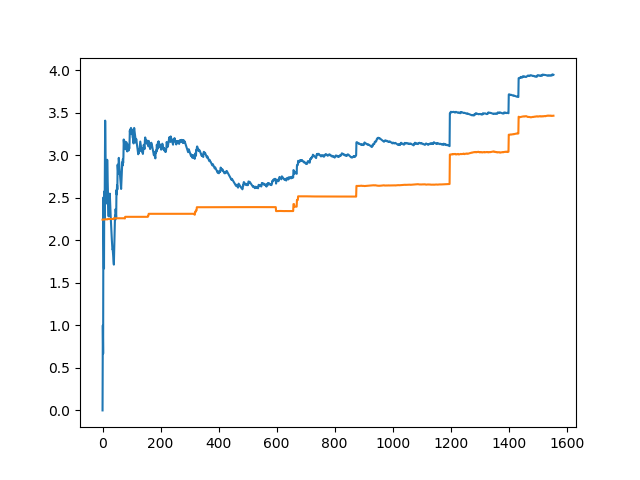

In [62]:
plt.figure()
plt.plot(range(len(xtrain)),np.asarray(error).T)
plt.plot(range(len(xtrain)),np.asarray(val).T)

Usando el metodo de propagación con RN

In [63]:
def pesosAleatorios(L_in, L_out):
    e_ini = 0.12
    pesos = np.random.uniform(-e_ini,e_ini,size=(L_out, L_in+1))
    return pesos

In [64]:
theta1 = pesosAleatorios(6,5)
theta2 = pesosAleatorios(5,4)

In [65]:
def propagacion (x,th):
    a = []
    unos = np.full((1728,1),1)
    for i in range(len(x)):
        z = np.dot(x[i],np.transpose(th))
        a.append(sigmoide(z))

    return np.append(unos,a, axis = 1)

In [66]:
f = propagacion(x,theta1)
f2 = propagacion(f,theta2)

In [67]:
f = np.copy(f2[:,1:])

In [68]:
testeo(y,f)

(69, 3.9930555555555554)

Utilizando RN con retropropagación.

In [69]:
def backprop (params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg ):
    th1 = np.reshape(params_rn [:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    th2 = np.reshape(params_rn [num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)    
    
    p = prop(X,th1,th2).T

    coste = coste_reg(p, Y, th1, th2, num_etiquetas, reg)
    grad = retro_prop(X, Y, th1, th2, reg, num_etiquetas)

    return coste, grad

In [70]:
def coste_no_reg(h,Y,num_etiquetas):  
    c = 0
    for i in range(num_etiquetas):
        y = (Y==i+1)*1
        c += sum(-y*(np.log(h[i])) - (1-y)*(np.log(1-h[i])))
        
    return c / Y.shape[0]

In [71]:
def coste_reg(h, Y, th1, th2, num_etiquetas, reg):
    m = Y.shape[0]
    th1[0] = 0
    th2[0] = 0
    c = coste_no_reg(h,Y,num_etiquetas)
    c += (sum(sum(th1**2)) + sum(sum(th2**2))) * (reg/m*2)
       
    return c

In [72]:
def deriv_sig(Z):
    sig = sigmoide(Z)
    return sig * (1 - sig)

In [73]:
def prop(X,th1,th2): 
    a1 = sigmoide(np.dot(X, th1.T))
    a1 = np.concatenate((np.ones([a1.shape[0],1]),a1),axis=1)
    a2 = sigmoide(np.dot(a1, th2.T))
    
    return a2

In [74]:
def retro_prop(X, Y, th1, th2, reg, num_etiquetas):    
    a1 = sigmoide(np.dot(X, theta1.T))
    a2 = np.concatenate((np.ones([a1.shape[0],1]),a1),axis=1)
    a3 = sigmoide(np.dot(a2, theta2.T))
    
    y = np.zeros((Y.shape[0],num_etiquetas))    
    for i in range (num_etiquetas):
        y[i, Y[i]-1] = 1 
        
    s3 = a3 - y
    s2 = np.dot(s3, th2)[:,1:]
    s2 = s2 * deriv_sig(np.dot(X, th1.T))
    delta1 = np.dot(s2.T, X)
    delta2 = np.dot(s3.T, a2)

    m = Y.shape[0]
    grad1 = delta1/m
    grad2 = delta2/m
    
    th1[:,1]=0
    th2[:,1]=0
    grad1 = grad1+(reg/m)*th1
    grad2 = grad2+(reg/m)*th2
    
    return np.concatenate((np.ravel(grad1),np.ravel(grad2))) 

In [75]:
def aprendNN(X, Y, params, num_entradas, num_ocultas, num_etiquetas, lamb, maxiter):
    fmin = opt.minimize(fun=backprop, x0=params, 
                        args=(num_entradas, num_ocultas, num_etiquetas, X, Y, lamb),
                        method='TNC', jac=True, options={'maxiter': maxiter})
    
    theta1 = np.reshape(fmin.x [:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(fmin.x [num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)
    
    res = prop(X,theta1,theta2)   
    result = np.argmax(res,axis=1)     
    result = (result+1 == (Y))*1
    
    porcentaje = (sum(result)*100) / Y.shape[0]

    return porcentaje

A partir de 33 iteraciones el valor alcanza su máximo por otro lado hemos comprobado que el valor de regularización afecta de manera anecdótica.

In [76]:
theta1 = pesosAleatorios(6,5)
theta2 = pesosAleatorios(5,4)

In [77]:
th1_opt = theta1
th2_opt = theta2

In [78]:
# Theta1 e s de dimensión 5 x 7
# Theta2 e s de dimensión 4 x 6
y = np.array(y.T)[0]    
theta_vec = np.concatenate((np.ravel(theta1),np.ravel(theta2)))
num_entradas = theta1.shape[1]-1
num_ocultas = theta1.shape[0]


In [80]:
aprendNN(data.astype('int'),y.astype('int'),theta_vec,num_entradas, num_ocultas, 4, 200, 200)

22.22222222222222